### Imports

In [1]:
import zipfile
import tarfile
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, BatchNormalization, Dropout, MaxPooling2D, Flatten, Conv2D, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve,  auc
from keras import Model

In [2]:
!nvidia-smi -L  

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
!nvidia-smi

GPU 0: Tesla T4 (UUID: GPU-ca865e4d-4613-1da7-0822-5d9d3ea924b6)
Found GPU at: /device:GPU:0
Fri Jun 10 20:33:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    25W /  70W |    264MiB / 15109MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+-------------------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
with zipfile.ZipFile('/content/drive/MyDrive/data/course_dataset_labeled.zip', 'r') as zip_ref:
    zip_ref.extractall('data/course_dataset_labeled')

### Attaching train and validation datasets with batching size

In [5]:
# Attaching train and validation datasets with batching size
batch_size = 10
image_size = 256

train_dir='/content/data/course_dataset_labeled/'

train_datagen = ImageDataGenerator(rescale = 1./255,validation_split = 0.2,rotation_range=5,width_shift_range=0.2,
                                height_shift_range=0.2,shear_range=0.2,horizontal_flip=True,vertical_flip=False,fill_mode='nearest')

train_dataset  = train_datagen.flow_from_directory(directory = train_dir,target_size = (image_size,image_size),class_mode = 'categorical',subset = 'training'
,batch_size = batch_size
) 
valid_dataset = train_datagen.flow_from_directory(directory = train_dir,target_size = (image_size,image_size),class_mode = 'categorical',subset = 'validation'
,batch_size = batch_size, shuffle = True
) 
#You can set shuffle=True to get the images in random order

Found 177 images belonging to 4 classes.
Found 42 images belonging to 4 classes.


In [6]:
train_dataset

In [7]:
classes = list(train_dataset.class_indices.keys())
print(classes)
#train_dataset.class_indices

['CT', 'N', 'O', 'TT']


### Print validation images example

(10, 256, 256, 3)
(256, 256, 3)


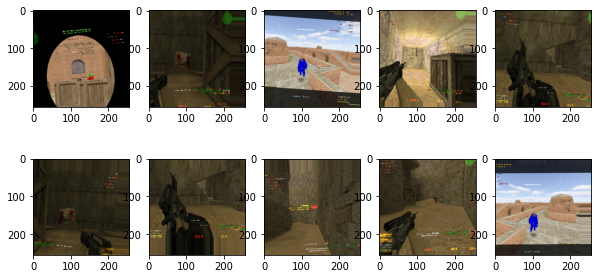

In [8]:
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

num_img_to_print = 10

fig = plt.figure(figsize=(10,5))
for i in range(num_img_to_print):
  test_batch=next(valid_dataset)  # returns the next batch of images and labels 
  if not i : print(test_batch[0].shape) # batch[0] is the images, batch[1] are the labels
  img=np.squeeze(test_batch[0][0])   # this is the first image  batch[0][1] would be the next image
  if not i: print (img.shape)
  fig.add_subplot(2, 5, i + 1)
  plt.imshow(img)   # shows the first image
plt.show()


# Plain 3-layer CNN

In [9]:
def get_model():
  model_plain=tf.keras.models.Sequential() 

  model_plain.add(Conv2D(32, kernel_size=(7, 7), activation='relu' ,name ='conv1'))
  model_plain.add(MaxPooling2D(3, 3))
  model_plain.add(BatchNormalization())
  model_plain.add(MaxPooling2D(2, 2, padding = 'same'))
  model_plain.add(Conv2D(32, kernel_size=(5, 5), padding = 'same', activation='relu' ,name ='conv2'))
  model_plain.add(BatchNormalization())
  model_plain.add(Conv2D(64, kernel_size=(3, 3), padding = 'same', activation='relu' ,name ='conv3'))
  model_plain.add(BatchNormalization())

  model_plain.add(MaxPooling2D(4, 4, padding = 'same'))
  model_plain.add(Dropout(0.25))
  model_plain.add(Flatten())

  model_plain.add(Dense(128, activation='relu'))
  model_plain.add(BatchNormalization())
  model_plain.add(Dropout(0.5))

  model_plain.add(Dense(128, activation='relu'))
  model_plain.add(BatchNormalization())
  model_plain.add(Dropout(0.3))

  model_plain.add(Dense(len(classes), activation='softmax')) # softmax обовязково на вихідному шарі нейронки для класифікації, він гарантує суму всіх виходів рівну 1

  model_plain.build(input_shape= test_batch[0].shape)

  model_plain.compile(optimizer=Adam(learning_rate=0.02),
                loss='categorical_crossentropy', 
                #loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  
  model_plain.summary()
  return model_plain

In [10]:
model_plain = get_model()
# Output_shape: batch_num|x|y|conv|

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (2, 250, 250, 32)         4736      
                                                                 
 max_pooling2d (MaxPooling2D  (2, 83, 83, 32)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (2, 83, 83, 32)          128       
 ormalization)                                                   
                                                                 
 max_pooling2d_1 (MaxPooling  (2, 42, 42, 32)          0         
 2D)                                                             
                                                                 
 conv2 (Conv2D)              (2, 42, 42, 32)           25632     
                                                        

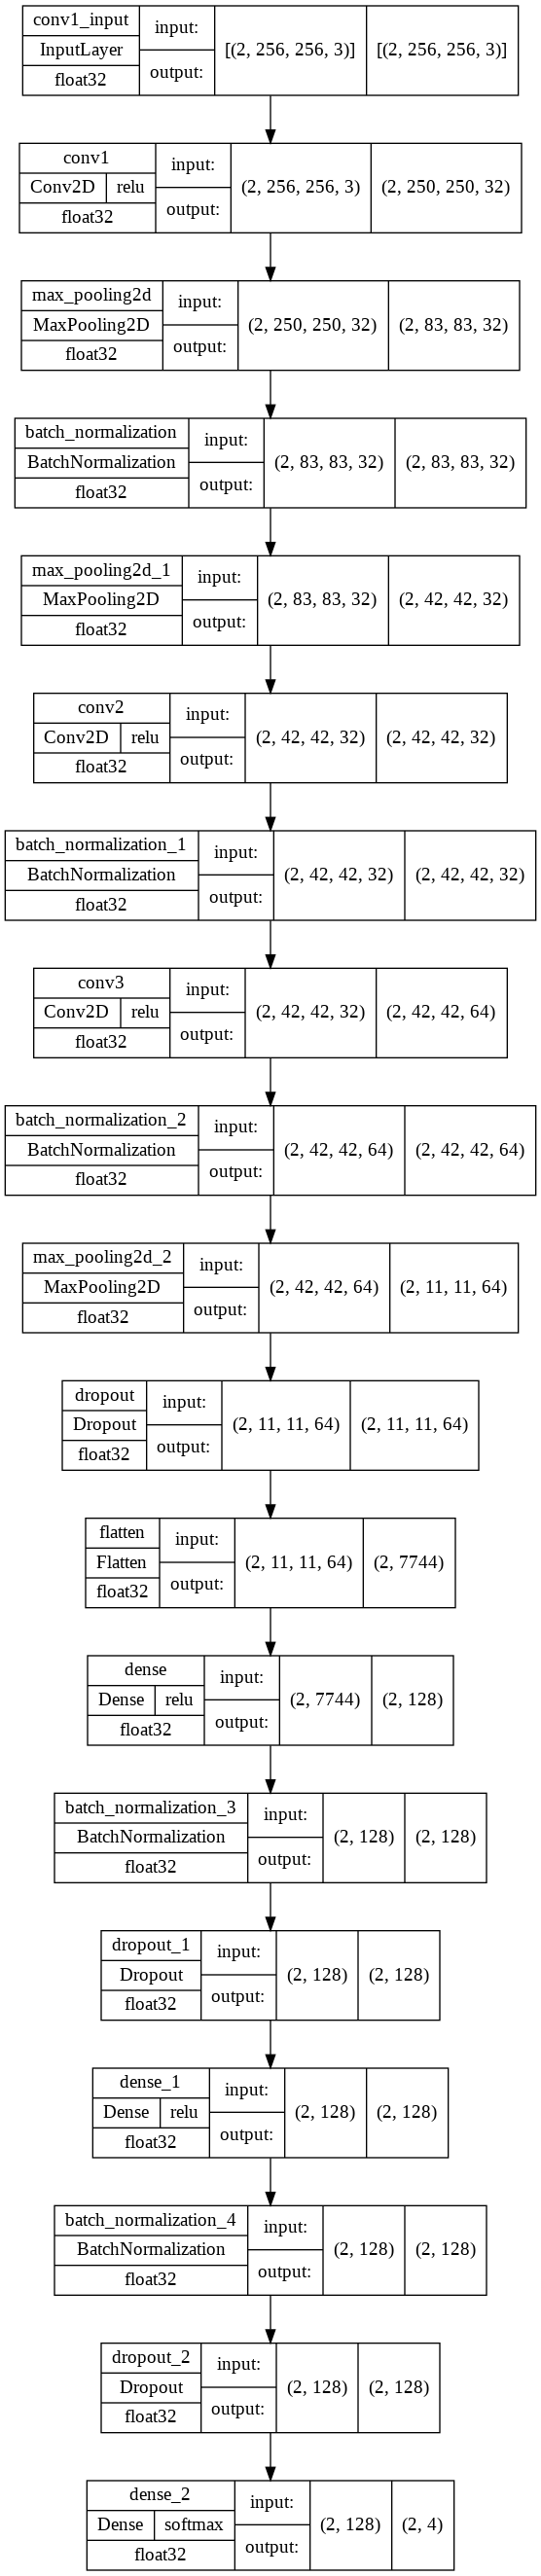

In [16]:
tf.keras.utils.plot_model(model_plain, to_file='model.png',
    show_shapes=True,
    show_dtype=True,
    expand_nested=True,
    show_layer_activations=True)

In [17]:
epochs = 50
#batch_size = 1000
history_plain=model_plain.fit(train_dataset,
                  validation_data=valid_dataset,
                  #batch_size = batch_size,
                  epochs = epochs,
                  verbose = 1,
                  callbacks=[
                       tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose = 1) # якщо результат loss не покращується n ітерацій
                       ]
                  )

Epoch 1/50
18/18 [==============================] - 26s 753ms/step - loss: 2.1602 - accuracy: 0.2599 - val_loss: 230.0371 - val_accuracy: 0.1429
Epoch 2/50
18/18 [==============================] - 13s 725ms/step - loss: 1.8776 - accuracy: 0.3164 - val_loss: 34.4336 - val_accuracy: 0.2857
Epoch 3/50
18/18 [==============================] - 13s 722ms/step - loss: 1.8220 - accuracy: 0.2825 - val_loss: 12.9908 - val_accuracy: 0.3571
Epoch 4/50
18/18 [==============================] - 13s 726ms/step - loss: 1.5619 - accuracy: 0.3277 - val_loss: 5.2352 - val_accuracy: 0.3333
Epoch 5/50
18/18 [==============================] - 13s 725ms/step - loss: 1.5859 - accuracy: 0.2994 - val_loss: 7.3347 - val_accuracy: 0.4048
Epoch 6/50
18/18 [==============================] - 13s 722ms/step - loss: 1.5691 - accuracy: 0.3729 - val_loss: 4.1459 - val_accuracy: 0.3095
Epoch 7/50
18/18 [==============================] - 13s 724ms/step - loss: 1.4536 - accuracy: 0.3672 - val_loss: 2.2702 - val_accuracy: 0.

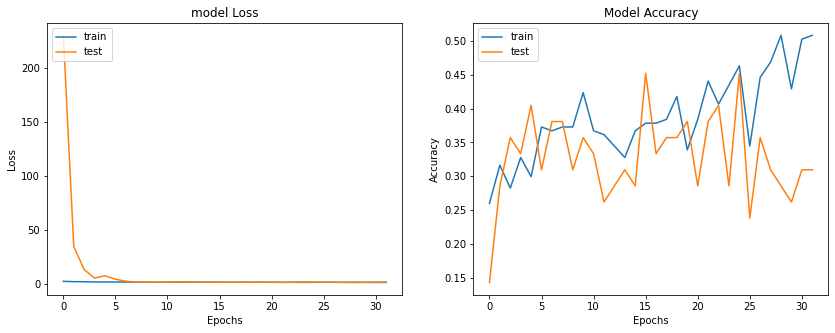

In [18]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(history_plain.history['accuracy'])
plt.plot(history_plain.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(history_plain.history['loss'])
plt.plot(history_plain.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**В результаті, маємо такий результат:**

115/115 [==============================] - 43s 374ms/step

loss: 2.7665 - accuracy: 0.3888 - val_loss: 2.7121 - val_accuracy: 0.3786


In [ ]:
model.save('model.h5')

# Attach train/validation results reported in the following forms:

### Ставимо дефолтною моделлю Plain 3-CNN, бо вона дала кращий результат

In [19]:
model = model_plain 

In [20]:
y_pred_prob = model.predict(valid_dataset)
y_pred = np.argmax(y_pred_prob, axis=1)
class_labels = valid_dataset.class_indices
class_labels = {v:k for k,v in class_labels.items()}
cm_train = confusion_matrix(valid_dataset.classes, y_pred)
print('Confusion Matrix')
print(cm_train)

Confusion Matrix
[[ 2  2  0 11]
 [ 2  1  0  4]
 [ 1  1  0  6]
 [ 4  2  0  6]]


In [ ]:
y_pred_prob = model.predict(train_dataset)
y_pred = np.argmax(y_pred_prob, axis=1)
class_labels = train_dataset.class_indices
class_labels = {v:k for k,v in class_labels.items()}
cm_train = confusion_matrix(train_dataset.classes, y_pred)
print('Confusion Matrix')
print(cm_train)

Confusion Matrix
[[30  9  4 18]
 [15  4  3  7]
 [20  6  3  6]
 [14  9  3 26]]


In [ ]:
y_pred_prob = model.predict(train_dataset)

In [ ]:
train_dataset.class_indices

{'CT': 0, 'N': 1, 'O': 2, 'TT': 3}

### Classification_report

In [21]:
# https://stackoverflow.com/questions/43162506/undefinedmetricwarning-f-score-is-ill-defined-and-being-set-to-0-0-in-labels-wi

print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(valid_dataset.classes, y_pred, labels=np.unique(y_pred), target_names=np.unique(target_names)))

Classification Report
              precision    recall  f1-score   support

          CT       0.22      0.13      0.17        15
           N       0.17      0.14      0.15         7
           O       0.22      0.50      0.31        12

   micro avg       0.21      0.26      0.24        34
   macro avg       0.20      0.26      0.21        34
weighted avg       0.21      0.26      0.21        34



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:2128: UserWarning: labels size, 3, does not match size of target_names, 4
  len(labels), len(target_names)


In [ ]:
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(train_dataset.classes, y_pred, labels=np.unique(y_pred), target_names=np.unique(target_names)))

Classification Report
              precision    recall  f1-score   support

          CT       0.38      0.49      0.43        61
           N       0.14      0.14      0.14        29
           O       0.23      0.09      0.13        35
          TT       0.46      0.50      0.48        52

    accuracy                           0.36       177
   macro avg       0.30      0.30      0.29       177
weighted avg       0.33      0.36      0.34       177



### Confusion matrix (valid dataset) 

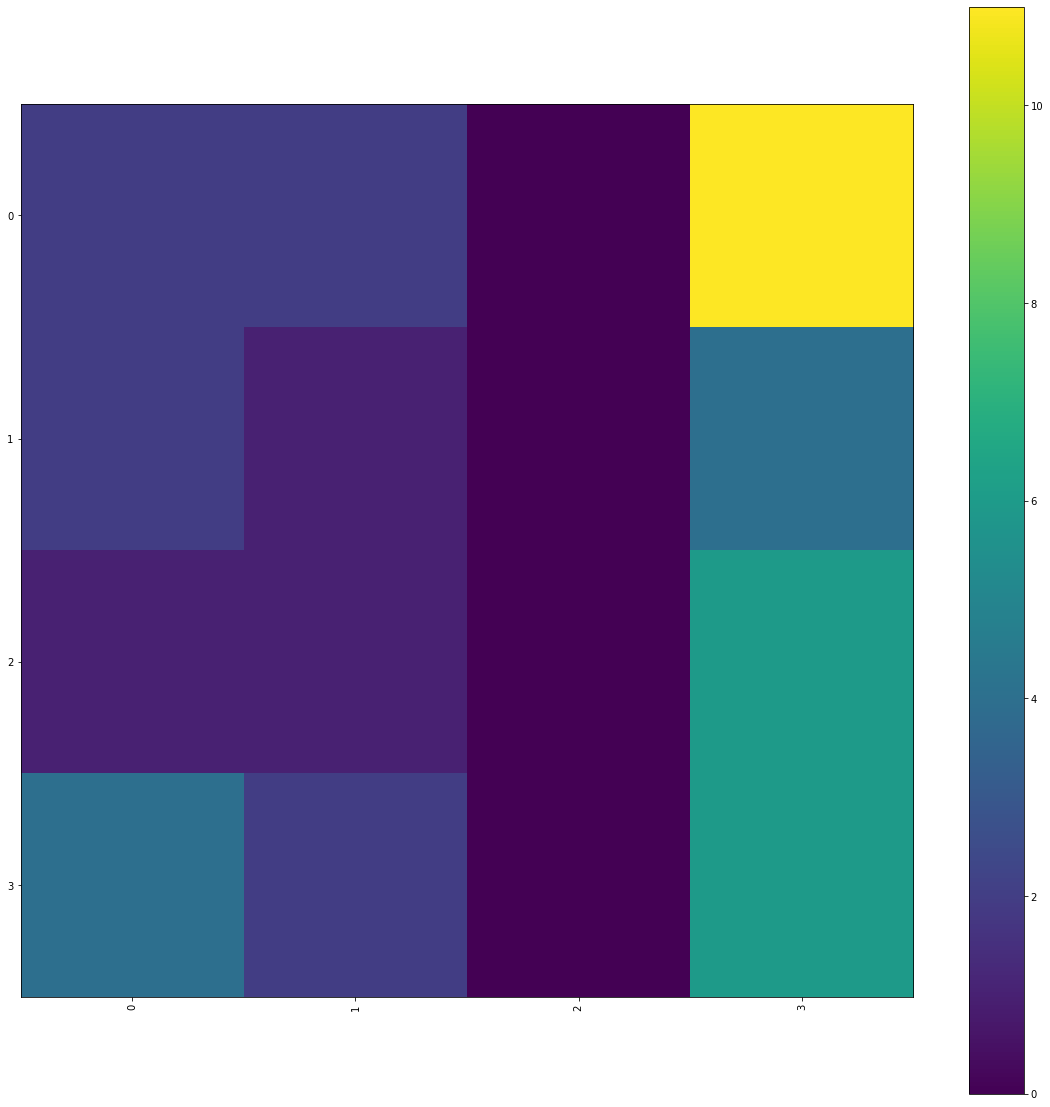

In [22]:
plt.figure(figsize=(20,20))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark,  rotation=90)
_ = plt.yticks(tick_mark)

#### Convert class vector to binary class matrix on validation dataset

In [23]:
y_true = tf.keras.utils.to_categorical(valid_dataset.classes, num_classes = len(classes))

### AUC-RPC plot (auc) will measure the ability of a classifier to distinguish between classes)

AUC Score: 0.45878047515302417


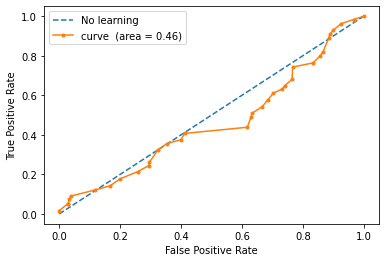

In [24]:
roc_fpr={}
roc_tpr={}
plt.plot([0,1], [0,1], linestyle='--', label='No learning')

for i in range(len(classes)):
  fpr, tpr, _ = roc_curve(y_true[:,i], y_pred_prob[:,i])
  roc_fpr[classes[i]] = fpr
  roc_tpr[classes[i]] = tpr
  
fpr = list(roc_fpr.values())
tpr = list(roc_tpr.values())

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(len(classes)): 
  mean_tpr += np.interp(all_fpr, fpr[i], tpr[i]) 
mean_tpr /= len(classes)
auc_score= auc(all_fpr, mean_tpr)
print("AUC Score:",auc_score)

plt.plot(all_fpr, mean_tpr, marker='.', label='curve  (area = {0:0.2f})'.format(auc_score))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()